In [4]:
from xtb.ase.calculator import XTB
from ase.io import read
import numpy as np
import nglview as nv
from ase.optimize import BFGS
from ase.io.trajectory import TrajectoryWriter
from ase.constraints import FixBondLengths
from ase.visualize import view
import matplotlib

%matplotlib widget
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
matplotlib.rc('axes.formatter', limits= (-3, 3))
plt.rcParams.update({'font.size': 14})

In [5]:
atoms = read('FEBPYCN4_large.pdb')
v = nv.show_ase(atoms)
v.add_label(labelType="atomindex")
v

NGLWidget()

Build some very simple translation. Move rings COM out... Basically

In [6]:
def translate(atoms, r):
    ''' Move rings COM radially away from metal.'''
    rings_idx = [2, 12, 19, 3, 8, 7, 6, 14, 11, 10, 4, 18, 0, 17, 1, 13, 9, 16, 5, 15]
    fe = 28
    ring_com = atoms[rings_idx].get_center_of_mass()
    v = ring_com - atoms[fe].position
    u = v / np.linalg.norm(v)
    
    pos = atoms.get_positions()
    pos[rings_idx] +=  r*u
    
    translated = atoms.copy()
    translated.set_positions(pos)
    return translated

In [7]:
rs = [x for x in np.arange(-0.5, 5.5)]

nonopted_traj = [translate(atoms, r) for r in rs]
v = view(nonopted_traj, viewer='ngl')
v

For each step in this trajectory, do a constrained opt using xtb, constraining the Fe-N distances (for example)
That means the angles can change.. And we also allow for the C-C bond to change, but it should be pretty strong so... well lets see.. 

In [34]:
traj = TrajectoryWriter('Weyhey.traj')
for i, atoms in enumerate(nonopted_traj):
    opt_atoms = atoms.copy()
    opt_atoms.calc = XTB(method="GFN2-xTB")
    opt_atoms.constraints = FixBondLengths([[28, 19],[28, 18]])
    opt = BFGS(atoms, trajectory=f'step_{i:02d}_opt.traj')
    opt.run(fmax=0.2)  # normal is 0.05 ev/Å² but i'm a bit lazy here, just for illustration
    traj.write(atoms)

      Step     Time          Energy         fmax
BFGS:    0 09:11:22    -1481.068708        3.0509
BFGS:    1 09:11:24    -1481.239082        0.9993
BFGS:    2 09:11:25    -1481.310147        1.8233
BFGS:    3 09:11:26    -1481.414619        1.6673
BFGS:    4 09:11:28    -1481.507543        0.7089
BFGS:    5 09:11:29    -1481.576733        1.7401
BFGS:    6 09:11:31    -1481.607641        1.3658
BFGS:    7 09:11:32    -1481.664283        0.5268
BFGS:    8 09:11:33    -1481.704350        0.3561
BFGS:    9 09:11:34    -1481.720036        0.5700
BFGS:   10 09:11:35    -1481.722370        0.9034
BFGS:   11 09:11:37    -1481.730160        0.2305
BFGS:   12 09:11:38    -1481.734094        0.2574
BFGS:   13 09:11:39    -1481.743908        0.3070
BFGS:   14 09:11:40    -1481.749598        0.7239
BFGS:   15 09:11:42    -1481.758309        0.3763
BFGS:   16 09:11:43    -1481.764193        0.2417
BFGS:   17 09:11:45    -1481.769559        0.1383
      Step     Time          Energy         fmax
BF

Why not calculate the scattering now we're at it lol

In [8]:
from ase.io import Trajectory
from grsq.debye import Debye

# somehow i managed also to update the nonopted_traj with the opted positions... so i'm making it again.
nonopted_traj = [translate(atoms, r) for r in rs]

traj = Trajectory('Weyhey.traj')
qvec = np.arange(0, 10, 0.05)
deb = Debye(qvec=qvec)
s_opt = np.zeros((len(qvec), len(traj)))
s_raw = np.zeros((len(qvec), len(traj)))
for i, atoms in enumerate(traj):
    s_opt[:, i] = deb.debye(atoms)
    s_raw[:, i] = deb.debye(nonopted_traj[i])

In [9]:
nv.show_asetraj(traj)

NGLWidget(max_frame=5)

That's proooobably not the greatest constraints or coordinate, but hey... It works for the illustration :D 

Aaanyways back to the scattering

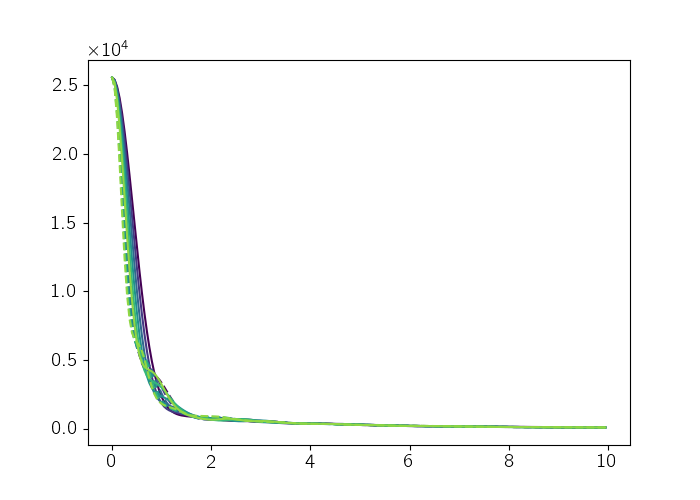

In [55]:
def make_colors(c, colmap='viridis'):
    ''' yes theres a much simpler way of doing this but i forgot it ok'''
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap(colmap)
    colors = [cmap(1.*i/c) for i in range(c)]
    return colors

col = make_colors(s_opt.shape[1])
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for i, (opt, raw) in enumerate(zip(s_opt.T, s_raw.T)):
    ax.plot(qvec, opt, color=col[i])
    ax.plot(qvec, raw, '--', color=col[i])

And then it should of course be some diff scattering, but... I should do my own work now.